In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Text preprocessing utilities
import re

In [9]:
# Load dataset
file_path = 'dataset.csv'  # Change to your file path
df = pd.read_csv(file_path)

# Display first few rows of the dataset
df.head()

,Unnamed: 0,links,symbol,company,Title,Text,Publishdate,Industry,Sentiment
0,3038,https://www.cnbc.com/2024/01/04/jim-cramer-rev...,NDAQ,"Nasdaq, Inc.",Jim Cramer reviews the worst performers on the...,CNBC's Jim Cramer on Thursday gave his take on...,4-Jan-24,Financial Services,0.0
1,1080,https://www.cnbc.com/2024/01/04/top-stocks-to-...,CMA,Comerica,Here are Thursday's biggest analyst calls: Nvi...,Here are the biggest calls on Wall Street on T...,4-Jan-24,Financial Services,0.0
2,222,https://www.cnbc.com/select/amex-centurion-new...,AXP,American Express,American Express is opening an exclusive club ...,Subscribe to the Select Newsletter! Our best s...,19-Jan-23,Financial Services,0.0
3,223,https://www.cnbc.com/select/american-express-c...,AXP,American Express,American Express Cardholders Get Free Drinks a...,The offer mentioned below is no longer availab...,12-Oct-22,Financial Services,0.0
4,224,https://www.cnbc.com/select/american-express-p...,AXP,American Express,American Express is partnering with TikTok to ...,Terms apply to American Express benefits and o...,14-Nov-22,Financial Services,0.0


In [11]:
df.columns

Index(['Unnamed: 0', 'links', 'symbol', 'company', 'Title', 'Text',
       'Publishdate', 'Industry', 'Sentiment'],
      dtype='object')

Basic Text Statistics:
Total Documents             4589.000000
Average Word Count           561.229426
Median Word Count            432.000000
Max Word Count              5895.000000
Min Word Count                 9.000000
Average Character Length    3479.227461
Empty Documents                8.000000
dtype: float64


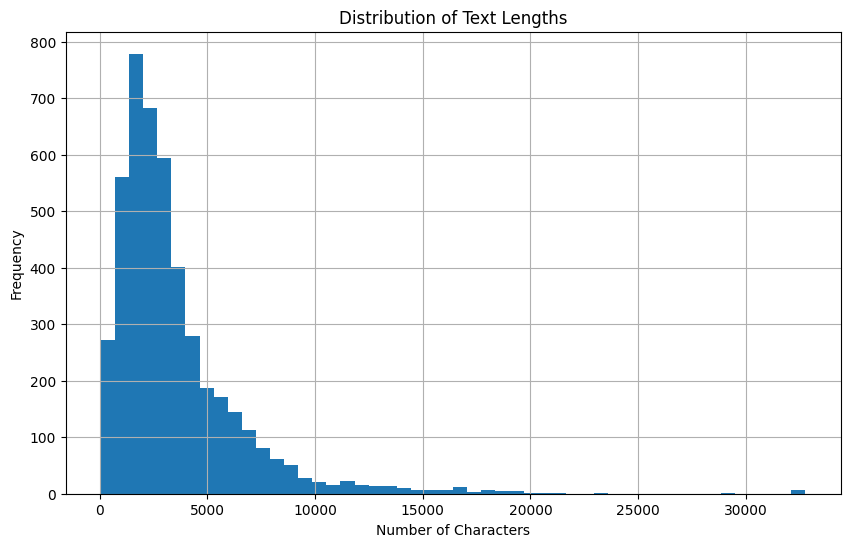

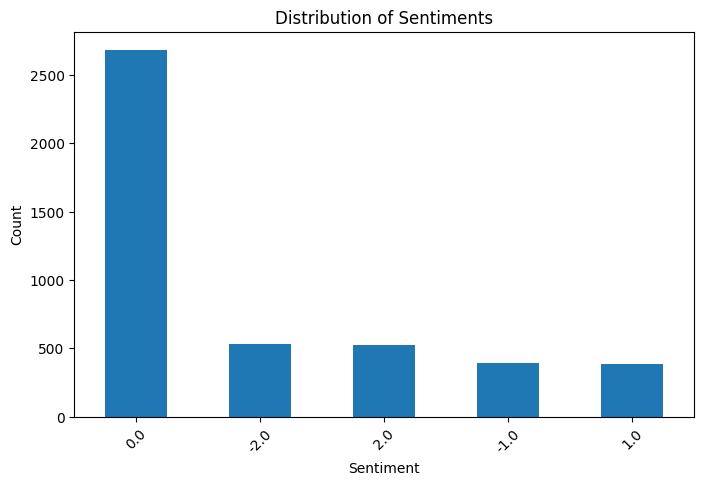


Most Common Words:
        Word  Frequency
0    company      16548
1       said      16526
2      share      11745
3      stock      11587
4       year       9453
5     market       6275
6       also       6159
7   earnings       5684
8      price       5210
9          u       5140
10   billion       5066
11       new       4945
12   analyst       4818
13       per       4773
14   revenue       4758
15       buy       4422
16  business       4205
17    growth       4151
18      bank       4109
19   quarter       4018


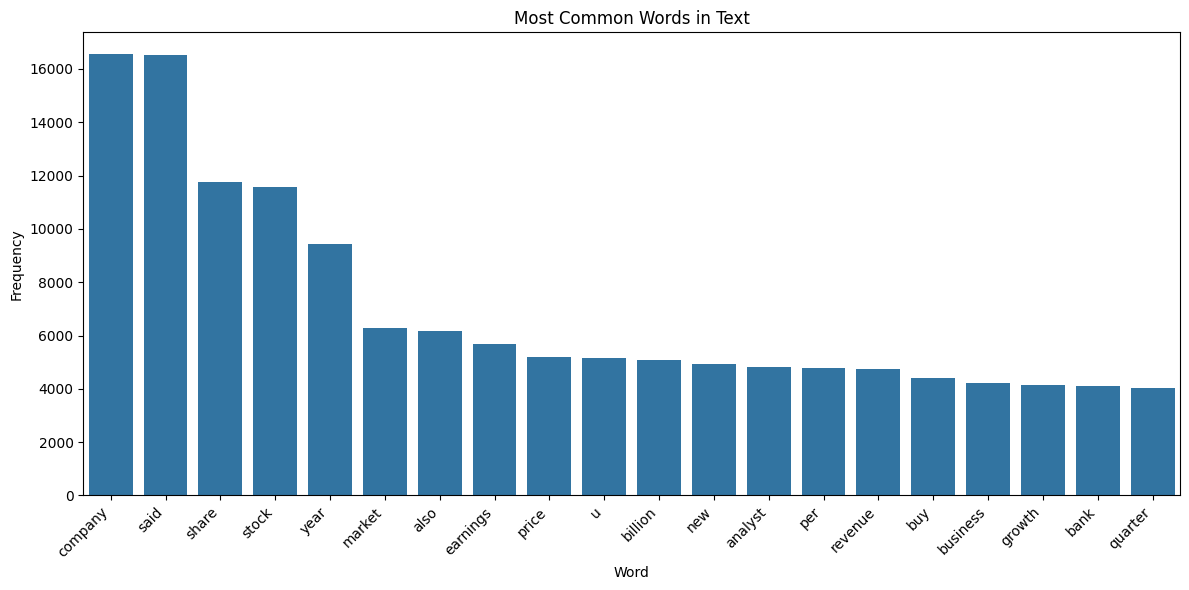

In [12]:
# Text statistics function
def get_text_stats(text_series):
    return pd.Series({
        'Total Documents': len(text_series),
        'Average Word Count': text_series.str.split().str.len().mean(),
        'Median Word Count': text_series.str.split().str.len().median(),
        'Max Word Count': text_series.str.split().str.len().max(),
        'Min Word Count': text_series.str.split().str.len().min(),
        'Average Character Length': text_series.str.len().mean(),
        'Empty Documents': text_series.isna().sum()
    })

# Display text statistics
text_stats = get_text_stats(df['Text'])
print("Basic Text Statistics:")
print(text_stats)

# Plot text length distribution
plt.figure(figsize=(10, 6))
df['Text'].str.len().hist(bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Text'] = df['Text'].astype(str).str.lower()
df['tokens'] = df['Text'].apply(tokenize)
df = df.drop_duplicates('Text')

# Get most common words
def get_common_words(text_series, top_n=20):
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    return pd.DataFrame(word_freq.most_common(top_n), columns=['Word', 'Frequency'])

common_words = get_common_words(df['tokens'])
print("\nMost Common Words:")
print(common_words)

# Plot most common words
plt.figure(figsize=(12, 6))
sns.barplot(data=common_words, x='Word', y='Frequency')
plt.title('Most Common Words in Text')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 10 words for 0.0 sentiment:
  Word  Frequency
0          787282
1    e     606286
2    r     376851
3    n     366595
4    l     244641
5    c     228801
6    p     148926
7    u     146529
8    g     137290
9    h     106748

Top 10 words for -2.0 sentiment:
  Word  Frequency
0          185431
1    e     145386
2    r      89204
3    n      84555
4    l      58499
5    c      53133
6    p      35800
7    u      35576
8    g      32136
9    h      24790

Top 10 words for 2.0 sentiment:
  Word  Frequency
0          185097
1    e     144643
2    r      89521
3    n      84351
4    l      57870
5    c      53625
6    p      36088
7    u      35434
8    g      32433
9    h      24735

Top 10 words for -1.0 sentiment:
  Word  Frequency
0          122982
1    e      96011
2    r      59632
3    n      57269
4    l      38794
5    c      35687
6    p      23907
7    u      23458
8    g      21770
9    h      16233

Top 10 words for 1.0 sentiment:
  Word  Frequency
0          117524
1    

<Figure size 2000x800 with 0 Axes>

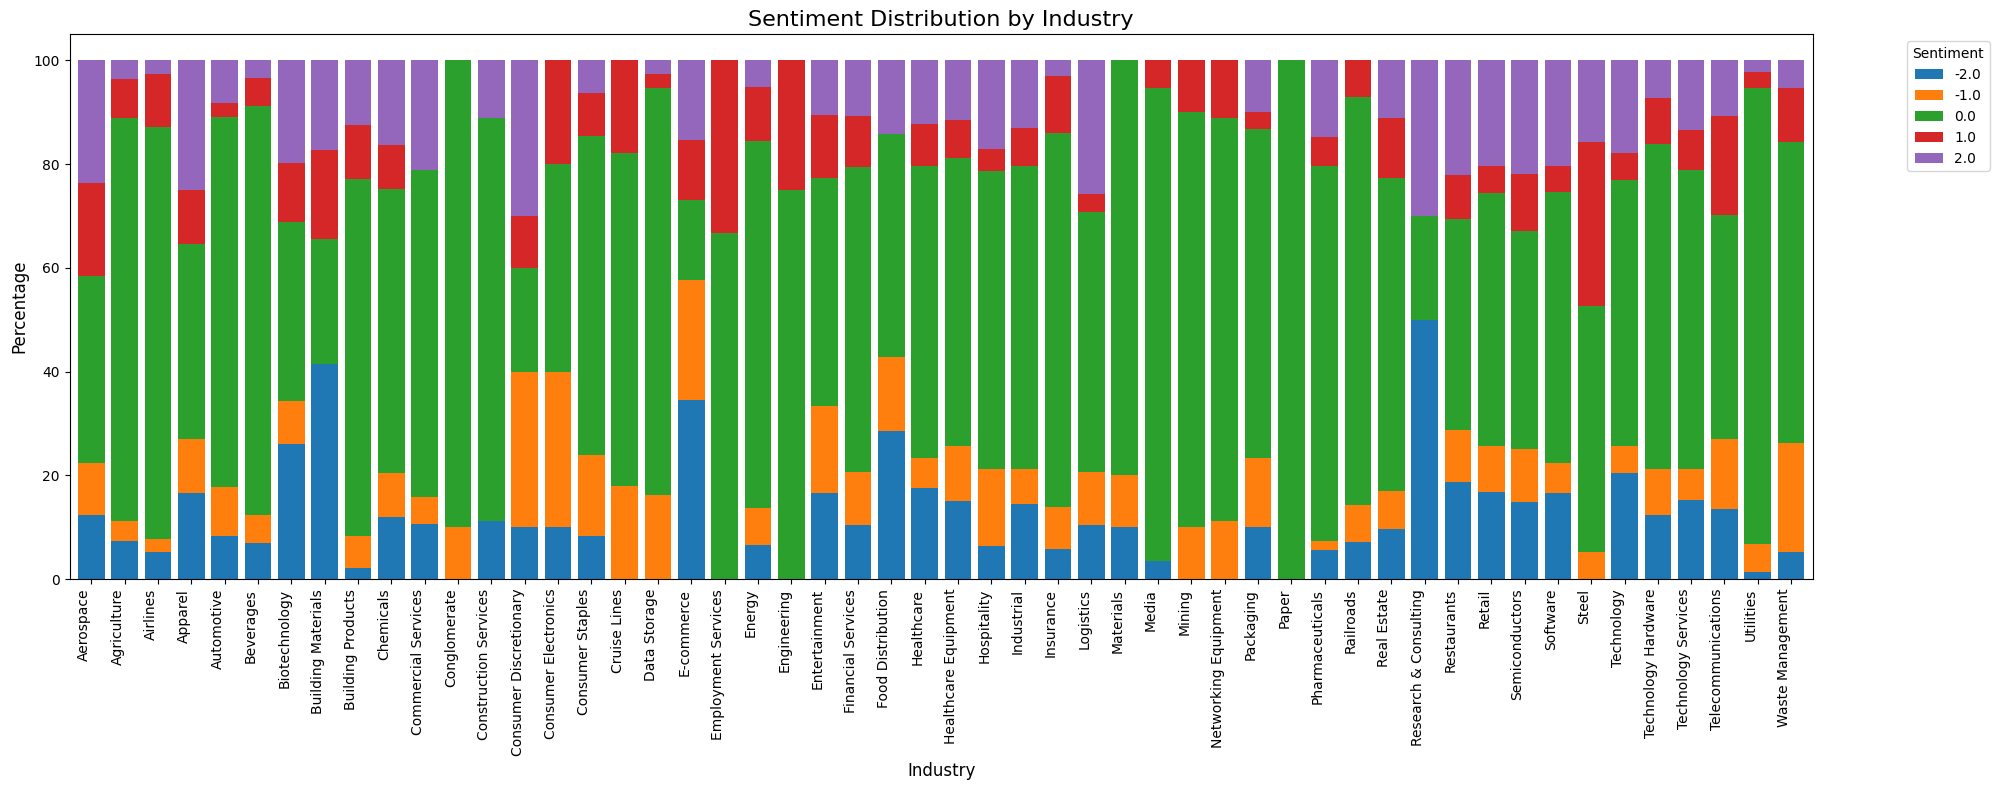

In [13]:
# Calculate words per sentiment
def words_by_sentiment(df):
    sentiment_words = {}
    for sentiment in df['Sentiment'].unique():
        texts = df[df['Sentiment'] == sentiment]['Text']
        all_words = []
        for text in texts:
            tokens = preprocess_text(text)
            all_words.extend(tokens)
        word_freq = Counter(all_words)
        sentiment_words[sentiment] = pd.DataFrame(word_freq.most_common(10), 
                                                columns=['Word', 'Frequency'])
    return sentiment_words

sentiment_words = words_by_sentiment(df)
for sentiment, words in sentiment_words.items():
    print(f"\nTop 10 words for {sentiment} sentiment:")
    print(words)

plt.figure(figsize=(20, 8))  # Set figure size

# Calculate sentiment distribution by industry as percentages
industry_sentiment = pd.crosstab(df['Industry'], df['Sentiment'], normalize='index') * 100

# Plot the bar chart
ax = industry_sentiment.plot(kind='bar', stacked=True, figsize=(20, 8), width=0.8)

# Customize x-axis labels
ax.set_xticklabels(industry_sentiment.index, rotation=90, ha='right')  # Rotate labels slightly for better alignment

# Add title, labels, and legend
plt.title('Sentiment Distribution by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Insight:

- **Lack of Unique Sentiment Terms**: No distinct terms consistently distinguish positive sentiment from negative sentiment.  
- **Context-Driven Sentiment**: Sentiment arises primarily from the context rather than specific word choices.  
- **Dominance of Financial Jargon**: Corporate financial terms appear consistently across all sentiment levels, making it harder to differentiate sentiment based on vocabulary


### Sector Insights on Sentiment

- **Tech Sectors**: Generally positive-leaning with moderate volatility.  
- **Healthcare**: Consistently positive with a strong neutral base.  
- **Financial**: More volatile with significant negative components.  
- **Consumer**: Tends toward neutral-positive sentiment.


### Conclusion and Reference for Future Analysis

Can develop a function to customize sentiment analysis by adjusting sentiment weights based on industry-specific baselines.

#### Key Highlights:
- **Industry-Specific Weights**: 
  - *Technology*: Positive weight (1.2), negative weight (0.8).  
  - *Energy*: Positive weight (0.8), negative weight (1.2).  
  - *Healthcare*: Positive weight (1.1), negative weight (0.9).  
- **Functionality**: Uses the `weighted_sentiment` function to calculate scores with adjusted weights.


In [ ]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# Your existing POS tagging function
def pos_tagging_and_chunking(text):
    doc = nlp(text)
    chunks = []
    for chunk in doc.noun_chunks:
        chunks.append((chunk.text, chunk.root.dep_, chunk.root.head.text))
    return chunks

# Assuming df['tokens'] exists
df['pos_chunks'] = df['tokens'].apply(pos_tagging_and_chunking)
df['pos_chunks']


In [ ]:
from collections import defaultdict
# 1. Analyze Dependency Patterns
dependency_patterns = defaultdict(int)
for chunks in df['pos_chunks']:
    for chunk, dep, _ in chunks:
        dependency_patterns[dep] += 1

# Visualize dependency patterns
plt.figure(figsize=(12, 6))
deps = pd.Series(dependency_patterns)
deps.sort_values(ascending=True).plot(kind='barh')
plt.title('Dependency Pattern Distribution')
plt.xlabel('Frequency')
plt.ylabel('Dependency Type')
plt.show()

print("Most common dependency patterns:")
print(deps.sort_values(ascending=False).head())

# 2. Mine Phrase Patterns
pattern_counter = defaultdict(int)
for chunks in df['pos_chunks']:
    for i in range(len(chunks) - 1):
        current_chunk = chunks[i]
        next_chunk = chunks[i + 1]
        pattern = f"{current_chunk[1]}_{next_chunk[1]}"
        pattern_counter[pattern] += 1

# Show top phrase patterns
print("\nMost common phrase patterns:")
patterns_series = pd.Series(pattern_counter)
print(patterns_series.sort_values(ascending=False).head(10))

# 3. Engineer POS Features
def get_pos_features(chunks):
    if not chunks:  # Handle empty chunks
        return {
            'chunk_count': 0,
            'unique_deps': 0,
            'subject_ratio': 0,
            'object_ratio': 0,
            'compound_ratio': 0
        }
    
    n_chunks = len(chunks)
    features = {
        'chunk_count': n_chunks,
        'unique_deps': len(set(dep for _, dep, _ in chunks)),
        'subject_ratio': sum(1 for _, dep, _ in chunks if dep == 'nsubj') / n_chunks,
        'object_ratio': sum(1 for _, dep, _ in chunks if dep == 'dobj') / n_chunks,
        'compound_ratio': sum(1 for _, dep, _ in chunks if dep == 'compound') / n_chunks
    }
    return features

# Apply features to all documents
pos_features = pd.DataFrame([get_pos_features(chunks) for chunks in df['pos_chunks']])
print("\nPOS Features Statistics:")
print(pos_features.describe())

# 4. Complex Pattern Recognition
def find_complex_patterns(chunks):
    patterns = {
        'cause_effect': 0,
        'comparison': 0,
        'condition': 0
    }
    
    if len(chunks) < 3:
        return patterns
        
    for i in range(len(chunks) - 2):
        triple = chunks[i:i+3]
        
        # Causal relationships
        if any(dep == 'mark' and head.lower() in ['because', 'since', 'as'] 
               for _, dep, head in triple):
            patterns['cause_effect'] += 1
            
        # Comparisons
        if any(dep == 'amod' and head.lower() in ['higher', 'lower', 'better', 'worse'] 
               for _, dep, head in triple):
            patterns['comparison'] += 1
            
        # Conditional statements
        if any(dep == 'mark' and head.lower() in ['if', 'unless', 'whether'] 
               for _, dep, head in triple):
            patterns['condition'] += 1
            
    return patterns

# Apply complex pattern recognition
complex_patterns = pd.DataFrame([find_complex_patterns(chunks) for chunks in df['pos_chunks']])

print("\nComplex Pattern Statistics:")
print(complex_patterns.sum())

# 5. Correlation Analysis
# Combine POS features with complex patterns for correlation analysis
analysis_df = pd.concat([pos_features, complex_patterns], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(analysis_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between POS Features and Complex Patterns')
plt.tight_layout()
plt.show()

# 6. Distribution of Features by Sentiment
# Assuming df['sentiment'] exists
if 'sentiment' in df.columns:
    features_by_sentiment = pd.concat([analysis_df, df['sentiment']], axis=1)
    
    # Plot box plots for key features across sentiment
    key_features = ['chunk_count', 'subject_ratio', 'cause_effect', 'comparison']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(key_features):
        sns.boxplot(x='sentiment', y=feature, data=features_by_sentiment, ax=axes[idx])
        axes[idx].set_title(f'{feature} by Sentiment')
    
    plt.tight_layout()
    plt.show()

# Print summary statistics
print("\nSummary of Key Findings:")
print(f"Average chunks per document: {pos_features['chunk_count'].mean():.2f}")
print(f"Most common dependency pattern: {deps.index[0]}")
print(f"Most common sequential pattern: {patterns_series.index[0]}")

In [13]:
def normalize_and_visualize_topic_weights(lda, vectorizer):
    """
    Normalize topic weights and extract top words per topic.
    Returns topic weights and top words DataFrames.
    """
    feature_names = vectorizer.get_feature_names_out()
    topic_term_matrix = lda.components_
    
    # Normalize weights
    normalized_weights = topic_term_matrix / topic_term_matrix.sum(axis=1)[:, np.newaxis]
    
    # Create DataFrame of weights
    topic_weights = pd.DataFrame(
        normalized_weights.T,
        index=feature_names,
        columns=[f"Topic #{i}" for i in range(normalized_weights.shape[0])]
    )
    
    # Get top words for each topic
    top_words = pd.DataFrame()
    for topic_idx, topic in enumerate(normalized_weights):
        # Get indices of words with highest weights
        top_indices = (-topic).argsort()[:10]  # Changed this line
        # Get the words and store them
        top_words[f"Topic #{topic_idx}"] = [feature_names[i] for i in top_indices]
    
    return topic_weights, top_words

def plot_topic_weights(topic_weights, top_words, num_topics=5, num_words=3):
    """
    Plot topic-word distributions as bubble plot.
    Bubble size represents word importance in topic.
    """
    plt.figure(figsize=(15, 8))
    
    # Create bubble plot
    for topic_idx in range(num_topics):
        topic_name = f"Topic #{topic_idx}"
        words = list(top_words[topic_name])[:num_words]
        weights = [topic_weights.loc[word, topic_name] for word in words]
        
        # Plot each word as a bubble
        for i, (word, weight) in enumerate(zip(words, weights)):
            # Create bubble - size corresponds to weight
            bubble = plt.scatter(topic_idx, i, 
                               s=weight*5000,  # Adjust multiplier for better visibility
                               alpha=0.6,
                               label=f"Topic {topic_idx}" if i == 0 else "")
            
            # Add word label in center of bubble
            plt.annotate(word, 
                        (topic_idx, i),
                        ha='center', va='center',  # Center the text
                        fontsize=10)
    
    plt.title("Topic Words Distribution")
    plt.xlabel("Topics")
    plt.ylabel("Top Words")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylim(-0.5, num_words-0.5)  # Adjust y-axis limits
    plt.xlim(-0.5, num_topics-0.5)  # Adjust x-axis limits
    
    plt.tight_layout()
    plt.show()

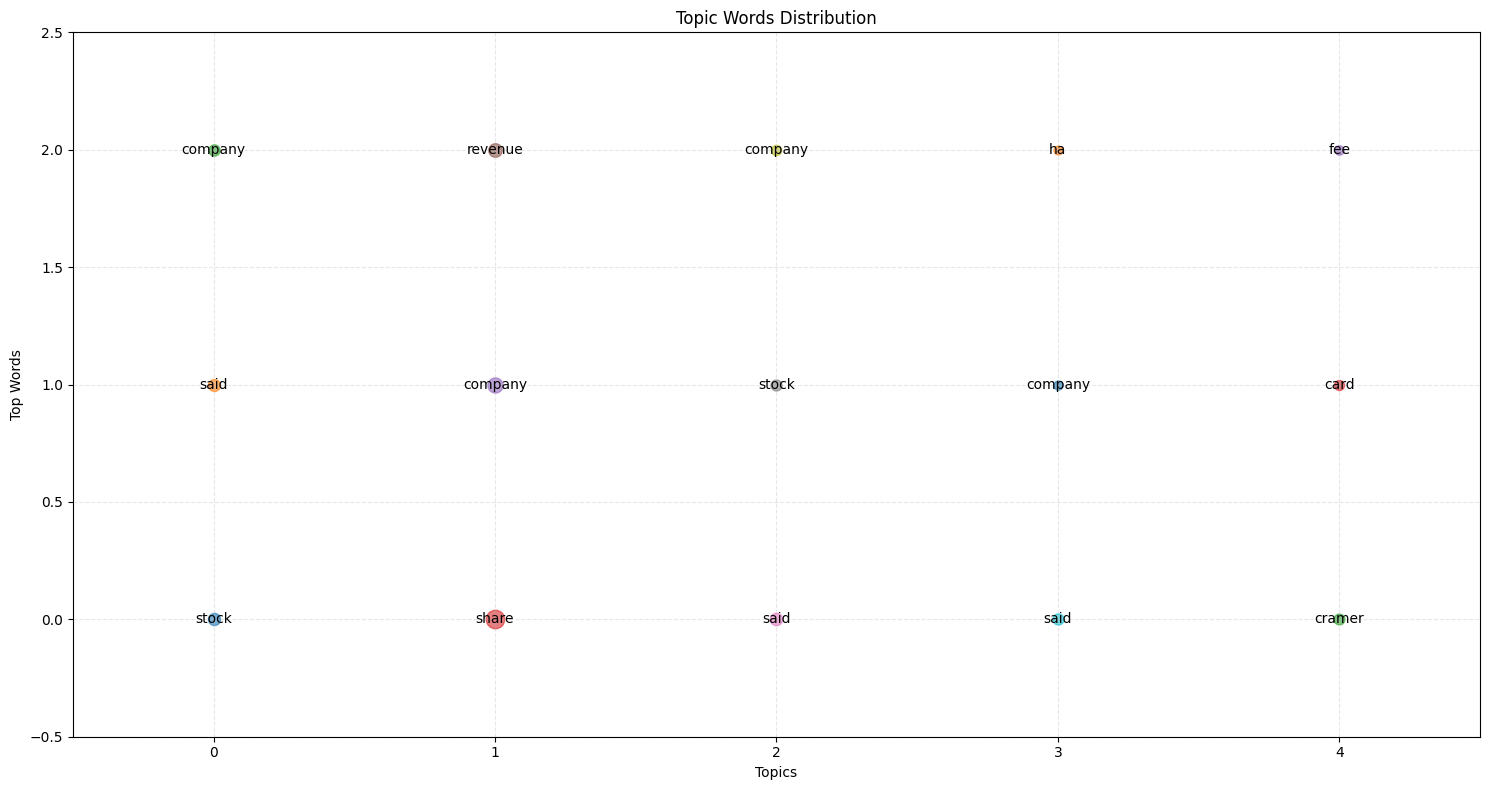

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Vectorize the preprocessed text
vectorizer = CountVectorizer(max_df=0.9, min_df=2) # Convert into numerical value
X = vectorizer.fit_transform(df['tokens'])

# LDA Topic Modelling
lda = LatentDirichletAllocation(n_components=5, random_state=42) # 5 topics to extract
lda_topics = lda.fit_transform(X)

# Visualize the results
def plot_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-top_n - 1:-1]]))

# Display LDA
# Generate and plot topic weights
topic_weights, top_words = normalize_and_visualize_topic_weights(lda, vectorizer)
plot_topic_weights(topic_weights, top_words, num_topics=5, num_words=3)

How to interpret this graph: \
Vertical axis: Contribution of the topic to this document \
Horizontal axis: Topic Index \
Bubble size: Weight of the topic

Fitting LDA with n_topics = 1
Perplexity for n_topics = 1: 3343.9280847164146
Fitting LDA with n_topics = 3
Perplexity for n_topics = 3: 2806.717597014647
Fitting LDA with n_topics = 5
Perplexity for n_topics = 5: 2638.775141563196
Fitting LDA with n_topics = 7
Perplexity for n_topics = 7: 2620.8447411895886
Fitting LDA with n_topics = 9
Perplexity for n_topics = 9: 2431.193226401706
Fitting LDA with n_topics = 11
Perplexity for n_topics = 11: 2399.4890525974924
Fitting LDA with n_topics = 13
Perplexity for n_topics = 13: 2382.1695586209494
Fitting LDA with n_topics = 15
Perplexity for n_topics = 15: 2372.1242992842544
Fitting LDA with n_topics = 17
Perplexity for n_topics = 17: 2363.4417247466617
Fitting LDA with n_topics = 19
Perplexity for n_topics = 19: 2355.749850326119
Fitting LDA with n_topics = 21
Perplexity for n_topics = 21: 2357.1447939838554
Fitting LDA with n_topics = 23
Perplexity for n_topics = 23: 2351.8127175137497
Fitting LDA with n_topics = 25
Perplexity for n_topics

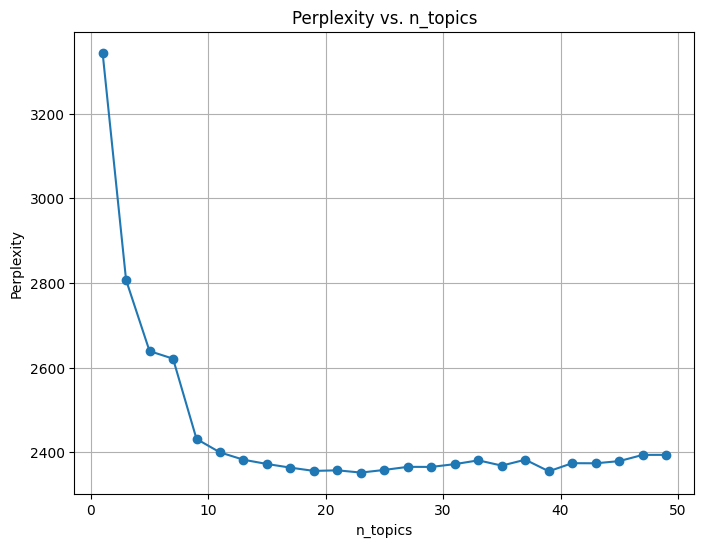

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss

# Define the different n_topics values to experiment with
n_topics_values = [x for x in range(1, 50, 2)]
perplexity_values = []

# Vectorize the data using TF-IDF
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['tokens'])

# Loop over different n_topics values
for n_topics in n_topics_values:
    print(f"Fitting LDA with n_topics = {n_topics}")
    
    # Initialize LDA with current n_topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42) 
    
    # Fit the LDA model
    lda_topics = lda.fit_transform(X)
    
    # Calculate and store the perplexity
    perplexity = lda.perplexity(X)
    perplexity_values.append(perplexity)
    
    print(f"Perplexity for n_topics = {n_topics}: {perplexity}")

# Plot perplexity vs. n_topics
plt.figure(figsize=(8, 6))
plt.plot(n_topics_values, perplexity_values, marker='o')
plt.title('Perplexity vs. n_topics')
plt.xlabel('n_topics')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

Fitting LDA with max_iter = 10
Perplexity for max_iter = 10: 2638.775141563196
Fitting LDA with max_iter = 11
Perplexity for max_iter = 11: 2629.6129390100314
Fitting LDA with max_iter = 12
Perplexity for max_iter = 12: 2621.6974792447872
Fitting LDA with max_iter = 13
Perplexity for max_iter = 13: 2615.162673552836
Fitting LDA with max_iter = 14
Perplexity for max_iter = 14: 2609.936392036991


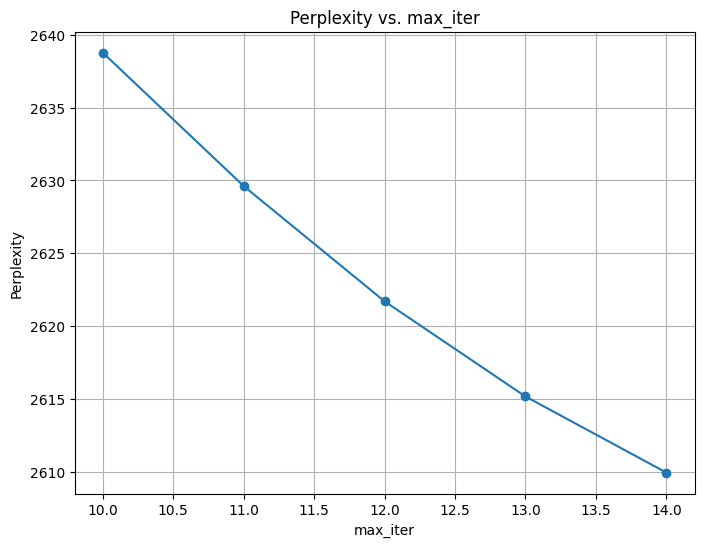

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss

# Define the different max_iter values to experiment with
max_iter_values = [x for x in range(10, 15, 1)]
perplexity_values = []

# Vectorize the data using TF-IDF
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['tokens'])

# Loop over different max_iter values
for max_iter in max_iter_values:
    print(f"Fitting LDA with max_iter = {max_iter}")
    
    # Initialize LDA with current max_iter
    lda = LatentDirichletAllocation(n_components=5, random_state=42, max_iter=max_iter) 
    
    # Fit the LDA model
    lda_topics = lda.fit_transform(X)
    
    # Calculate and store the perplexity
    perplexity = lda.perplexity(X)
    perplexity_values.append(perplexity)
    
    print(f"Perplexity for max_iter = {max_iter}: {perplexity}")

# Plot perplexity vs. max_iter
plt.figure(figsize=(8, 6))
plt.plot(max_iter_values, perplexity_values, marker='o')
plt.title('Perplexity vs. max_iter')
plt.xlabel('max_iter')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['tokens'])

In [18]:
# LDA Topic Modelling
lda = LatentDirichletAllocation(n_components=30, random_state=42)
lda_topics = lda.fit_transform(X)

print(f"Perplexity value: {lda.perplexity(X)}")

Perplexity value: 2373.132808918084


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_topic_coherence(model, X):
    # Calculate pairwise similarities between topics
    topic_vectors = model.components_
    similarities = cosine_similarity(topic_vectors)
    
    # Average similarity (excluding self-similarity)
    n_topics = len(topic_vectors)
    coherence = (similarities.sum() - n_topics) / (n_topics * (n_topics - 1))
    
    return coherence

print(f"Topic Coherence Score: {calculate_topic_coherence(lda, X):.4f}")

Topic Coherence Score: 0.2683


In [20]:
# Dependency Parsing using Spacy
def dependency_parsing(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Apply to preprocessed text
df['dependency_parsing'] = df['tokens'].apply(dependency_parsing)

# Check output
print(f"Title: {df['text'].head()[0]}")
print(f"Dependency Parsing: {df['dependency_parsing'].head()[0]}")

Title: CNBC's Jim Cramer on Thursday gave his take on the worst performers in the Nasdaq-100 in 2023.

Cramer compared each company's closing price in 2022 to the end of 2023, noting the biggest losers. The list included healthcare companies as well as several utilities outfits.

"You've heard of the Dogs of the Dow? Well, now I want to talk to you about the Gnats of the Nasdaq, the worst performers in the Nasdaq-100 for 2023," Cramer said. "Just like the dogs of the Dow, maybe, just maybe, there are some quality stocks here that are ready to make a comeback."
Dependency Parsing: [('cnbcs', 'compound', 'cramer'), ('jim', 'compound', 'cramer'), ('cramer', 'nsubj', 'gave'), ('thursday', 'npadvmod', 'gave'), ('gave', 'ROOT', 'gave'), ('take', 'xcomp', 'gave'), ('worst', 'amod', 'performer'), ('performer', 'compound', 'cramer'), ('nasdaq', 'compound', 'cramer'), ('cramer', 'nsubj', 'compared'), ('compared', 'prep', 'gave'), ('company', 'nmod', 'price'), ('closing', 'compound', 'price'), ('

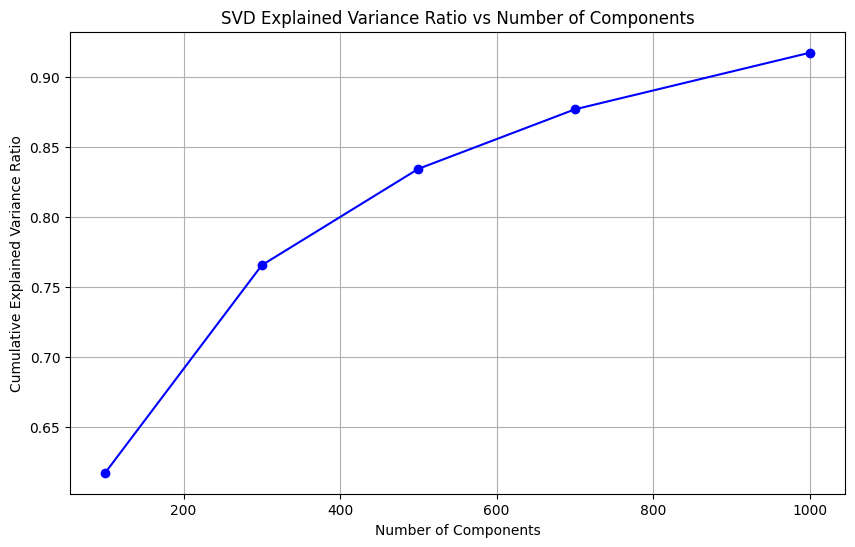

In [21]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Create SVD with varying components
n_components_range = [100, 300, 500, 700, 1000]  # Testing up to 20 components
variance_ratios = []

for n in n_components_range:
    svd = TruncatedSVD(n_components=n)
    svd.fit(X)
    variance_ratios.append(svd.explained_variance_ratio_.sum())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, variance_ratios, 'bo-')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('SVD Explained Variance Ratio vs Number of Components')
plt.show()

In [22]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# POS Tagging and Chunking Function
def pos_tagging_and_chunking(text):
    doc = nlp(text)
    chunks = []
    for chunk in doc.noun_chunks: # Here only noun chunks are extracted
        chunks.append((chunk.text, chunk.root.dep_, chunk.root.head.text)) # chunk text, dependency label, head text
    return chunks

# Apply to the preprocessed text
df['pos_chunks'] = df['tokens'].apply(pos_tagging_and_chunking)

# Check output
print(f"Tokens: {df['tokens'].head()[0]}")
print(f"POS Chunks: {df['pos_chunks'].head()[0]}")

# The POS chunks show extracted noun phrases with their dependency information.

Tokens: cnbcs jim cramer thursday gave take worst performer nasdaq cramer compared company closing price end noting biggest loser list included healthcare company well several utility outfit youve heard dog dow well want talk gnat nasdaq worst performer nasdaq cramer said like dog dow maybe maybe quality stock ready make comeback
POS Chunks: [('cnbcs jim cramer', 'nsubj', 'gave'), ('worst performer nasdaq cramer', 'nsubj', 'compared'), ('company closing price end', 'dobj', 'compared'), ('biggest loser list', 'nsubj', 'included'), ('healthcare company', 'dobj', 'included'), ('several utility outfit', 'nsubj', 'want'), ('you', 'nsubj', 'heard'), ('dog dow', 'nsubj', 'want'), ('talk gnat', 'dobj', 'want'), ('nasdaq worst performer nasdaq cramer', 'nsubj', 'said'), ('dog dow', 'pobj', 'like'), ('quality stock', 'nsubj', 'make'), ('comeback', 'dobj', 'make')]


In [23]:
text = df['tokens'][0]
text

'cnbcs jim cramer thursday gave take worst performer nasdaq cramer compared company closing price end noting biggest loser list included healthcare company well several utility outfit youve heard dog dow well want talk gnat nasdaq worst performer nasdaq cramer said like dog dow maybe maybe quality stock ready make comeback'

In [24]:
from collections import defaultdict
nlp = spacy.load('en_core_web_sm')

text = df['tokens'][0]
doc = nlp(text)
features = {}

# POS features
pos_counts = defaultdict(int)
for token in doc:
    pos_counts[f'pos_{token.pos_}'] += 1
total_tokens = len(doc)
for pos, count in pos_counts.items():
    features[pos] = count / total_tokens if total_tokens > 0 else 0

# Special POS ratios
features['pos_adj_adv_ratio'] = (
    (pos_counts['pos_ADJ'] + pos_counts['pos_ADV']) / total_tokens 
    if total_tokens > 0 else 0
)

features

{'pos_PROPN': 0.21568627450980393,
 'pos_VERB': 0.17647058823529413,
 'pos_ADJ': 0.0784313725490196,
 'pos_NOUN': 0.37254901960784315,
 'pos_INTJ': 0.0196078431372549,
 'pos_PRON': 0.0196078431372549,
 'pos_AUX': 0.0196078431372549,
 'pos_ADV': 0.0784313725490196,
 'pos_ADP': 0.0196078431372549,
 'pos_adj_adv_ratio': 0.1568627450980392}

In [25]:
features.update({
    'dep_has_negation': int(any(token.dep_ == 'neg' for token in doc)),
    'dep_root_verbs': len([token for token in doc if token.dep_ == 'ROOT' and token.pos_ == 'VERB']),
    'dep_avg_subtree': np.mean([len(list(token.subtree)) for token in doc]) if len(doc) > 0 else 0,
})

In [26]:
{
    'dep_has_negation': int(any(token.dep_ == 'neg' for token in doc)),
    'dep_root_verbs': len([token for token in doc if token.dep_ == 'ROOT' and token.pos_ == 'VERB']),
    'dep_avg_subtree': np.mean([len(list(token.subtree)) for token in doc]) if len(doc) > 0 else 0,
}

{'dep_has_negation': 0,
 'dep_root_verbs': 1,
 'dep_avg_subtree': 4.294117647058823}

In [27]:
# NER features
ent_counts = defaultdict(int)
for ent in doc.ents:
    ent_counts[f'ner_{ent.label_}'] += 1
features.update(ent_counts)
features['ner_density'] = len(doc.ents) / len(doc) if len(doc) > 0 else 0

In [26]:
features

{'pos_PROPN': 0.21568627450980393,
 'pos_VERB': 0.17647058823529413,
 'pos_ADJ': 0.0784313725490196,
 'pos_NOUN': 0.37254901960784315,
 'pos_INTJ': 0.0196078431372549,
 'pos_PRON': 0.0196078431372549,
 'pos_AUX': 0.0196078431372549,
 'pos_ADV': 0.0784313725490196,
 'pos_ADP': 0.0196078431372549,
 'pos_adj_adv_ratio': 0.1568627450980392,
 'dep_has_negation': 0,
 'dep_root_verbs': 1,
 'dep_avg_subtree': 4.294117647058823,
 'ner_PERSON': 3,
 'ner_DATE': 1,
 'ner_density': 0.0784313725490196}

In [28]:
{'ner_DATE': 6,
 'ner_ORG': 6,
 'ner_ORDINAL': 1,
 'ner_PERSON': 10,
 'ner_CARDINAL': 3,
 'ner_LOC': 1,
 'ner_TIME': 1,
 'ner_density': 0.03910614525139665}

{'ner_DATE': 6,
 'ner_ORG': 6,
 'ner_ORDINAL': 1,
 'ner_PERSON': 10,
 'ner_CARDINAL': 3,
 'ner_LOC': 1,
 'ner_TIME': 1,
 'ner_density': 0.03910614525139665}

In [31]:
df = df.dropna()

Gaussian Process Results:
MSE: 1.0264
R2 Score: 0.0002


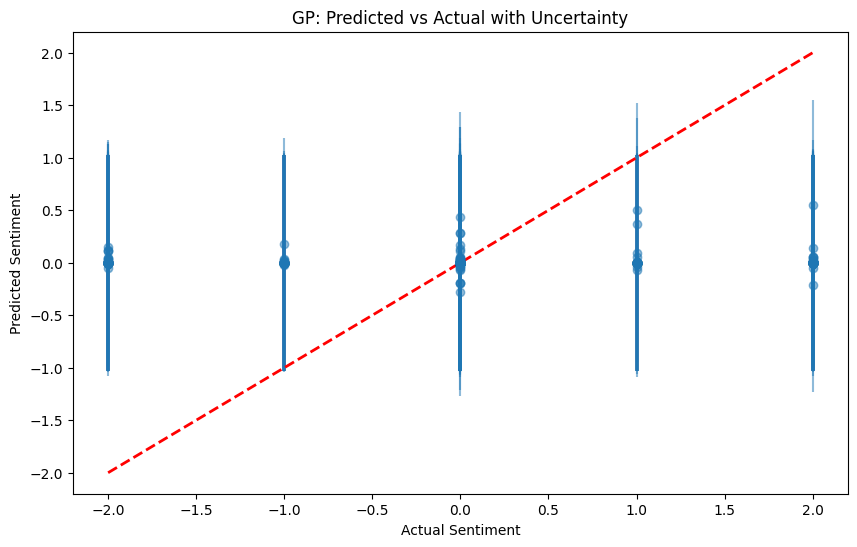


Extreme Learning Machine Results:
MSE: 1.0705
R2 Score: -0.0428


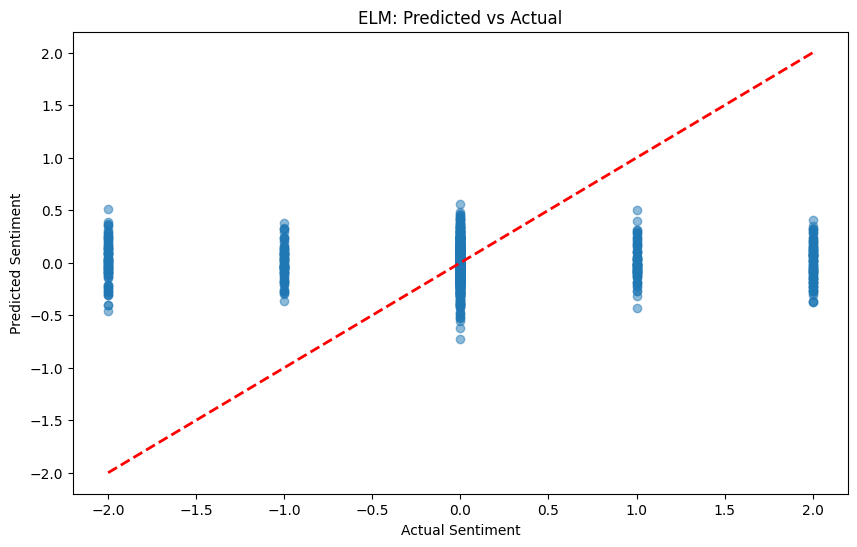

In [32]:
# %% [markdown]
# # Gaussian Process and Extreme Learning Machine Implementation
# 
# ## Gaussian Process Intuition
# Gaussian Process (GP) is a non-parametric model that defines a probability distribution over functions.
# Key points:
# - It's based on the assumption that any finite collection of points follows a multivariate normal distribution
# - Uses kernels to measure similarity between points
# - Provides uncertainty estimates naturally
# - Great for smaller datasets where uncertainty quantification is important

# %%
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare data for modeling
# We'll use the sentiment as our target variable
X = df[['tokens']].copy()  # Using preprocessed text
y = df['sentiment'].values

# Convert text to numerical features using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)  # Limiting features for computational efficiency
X = vectorizer.fit_transform(X['tokens']).toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %% [markdown]
# ## Implementing Gaussian Process

# %%
# Define and train GP model
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
gp.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gp = gp.predict(X_test_scaled)
y_pred_std = np.sqrt(gp.predict(X_test_scaled, return_std=True)[1])

# Evaluate GP model
mse_gp = mean_squared_error(y_test, y_pred_gp)
r2_gp = r2_score(y_test, y_pred_gp)

print("Gaussian Process Results:")
print(f"MSE: {mse_gp:.4f}")
print(f"R2 Score: {r2_gp:.4f}")

# Visualize predictions vs actual with uncertainty
plt.figure(figsize=(10, 6))
plt.errorbar(y_test, y_pred_gp, yerr=y_pred_std, fmt='o', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sentiment')
plt.ylabel('Predicted Sentiment')
plt.title('GP: Predicted vs Actual with Uncertainty')
plt.show()

# %% [markdown]
# ## Extreme Learning Machine Intuition
# ELM is a single-hidden layer feedforward neural network where:
# - Input weights are randomly assigned
# - Hidden layer biases are randomly assigned
# - Output weights are analytically determined
# - Very fast training compared to traditional neural networks
# - Good generalization for many problems

# %%
class ELM:
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        # Random weights and biases
        self.input_weights = np.random.normal(size=[X.shape[1], self.n_hidden])
        self.biases = np.random.normal(size=[self.n_hidden])
        
        # Calculate hidden layer output
        H = self._sigmoid(np.dot(X, self.input_weights) + self.biases)
        
        # Calculate output weights
        self.output_weights = np.dot(np.linalg.pinv(H), y)
        
    def predict(self, X):
        H = self._sigmoid(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

# Train and evaluate ELM
elm = ELM(n_hidden=100)
elm.fit(X_train_scaled, y_train)
y_pred_elm = elm.predict(X_test_scaled)

# Evaluate ELM model
mse_elm = mean_squared_error(y_test, y_pred_elm)
r2_elm = r2_score(y_test, y_pred_elm)

print("\nExtreme Learning Machine Results:")
print(f"MSE: {mse_elm:.4f}")
print(f"R2 Score: {r2_elm:.4f}")

# Visualize ELM predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_elm, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sentiment')
plt.ylabel('Predicted Sentiment')
plt.title('ELM: Predicted vs Actual')
plt.show()

# %% [markdown]
# ## Model Comparison and Evaluation
# 
# Let's compare both models:
# 1. Gaussian Process:
#    - Provides uncertainty estimates
#    - Better suited for smaller datasets
#    - Computationally more intensive
#    - R2 Score: {r2_gp:.4f}
#
# 2. Extreme Learning Machine:
#    - Faster training time
#    - Scales better with larger datasets
#    - No uncertainty estimates
#    - R2 Score: {r2_elm:.4f}
#
# The choice between these models depends on:
# - Dataset size
# - Need for uncertainty estimates
# - Computational resources
# - Required inference speed